In [1]:
import sys
import os
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)

In [2]:
from bimpcc.dataset import get_blur_dataset
from bimpcc.dataset import get_dataset
import numpy as np
import scipy.sparse as sp
from bimpcc.models.recons_regularized import TVReconsRegularized
from bimpcc.models.tvreconstruction_model import TVReconstructionMPCC
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
def plot_experiment(true,noisy,u, alpha):
    
    fig,ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].imshow(true,cmap='gray')
    ax[0].set_title('True Image')
    ax[0].axis('off')
    ax[1].imshow(noisy,cmap='gray')
    ax[1].set_title('Noisy Image\nPSNR: {:.4f}'.format(psnr(true,noisy)))
    ax[1].axis('off')
    ax[2].imshow(u,cmap='gray')
    ax[2].set_title(f'Reconstructed Image\nPSNR: {psnr(true,u):.4f}\n alpha = {alpha}')
    # ax[2].set_xlabel('alpha = {}'.format(alpha))
    ax[2].axis('off')

    plt.show()

In [4]:
scale = 20

In [5]:
dataset = get_blur_dataset("cameraman",scale=scale)
# dataset = get_dataset("cameraman",scale=scale)
true, blurred = dataset.get_training_data()

(np.float64(-0.5), np.float64(19.5), np.float64(19.5), np.float64(-0.5))

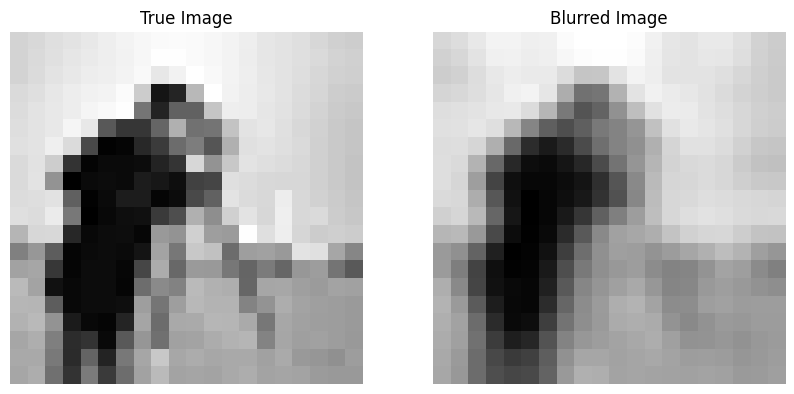

In [6]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(true,cmap='gray')
ax[0].set_title('True Image')
ax[0].axis('off')
ax[1].imshow(blurred,cmap='gray')
ax[1].set_title('Blurred Image')
ax[1].axis('off')

In [7]:
from bimpcc.utils import gaussian_blur_sparse_matrix_symmetric
forward_map = gaussian_blur_sparse_matrix_symmetric(true.shape)
# forward_map = sp.eye(np.prod(true.shape))
model = TVReconsRegularized(forward_map, true, blurred, epsilon=1e-3)

In [8]:
res,x_opt,fun_opt = model.solve(max_iter=3000,tol=1e-4,print_level=5)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    14840
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1161
                     variables with only lower bounds:      401
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1160
Total number of inequality c

In [9]:
u, q, alpha = model.objective_func.parse_vars(x_opt)

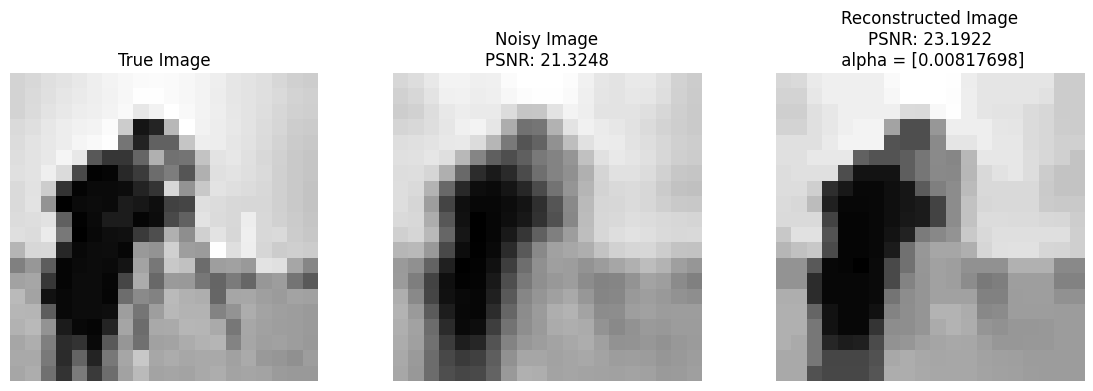

In [10]:
u = u.reshape((scale,scale))
plot_experiment(true,blurred,u,alpha)

In [11]:
m = q.flatten().size
n = m // 2
Ku = model.K @ u.flatten()
V = Ku.reshape(2, -1).T
normKu = np.apply_along_axis(np.linalg.norm, axis=1, arr=V)
Q = q.reshape(2,-1).T
normQ = np.apply_along_axis(np.linalg.norm, axis=1, arr=Q)
r0 = normKu
delta0 = normQ

In [12]:
Kxu = Ku[:n]  # Primeras n componentes
Kyu = Ku[n:]  # Últimas n componentes
qx = q[:n]  # Primeras n componentes
qy = q[n:]  # Últimas n componentes
epsilon = 1e-10  

# Condiciones para calcular theta según los casos dados
theta0 = np.zeros(n)  # Inicializamos theta0

# Caso 1: r_i ≠ 0
mask_r_nonzero = r0 > epsilon
theta0[mask_r_nonzero] = np.arccos(Kxu[mask_r_nonzero] / r0[mask_r_nonzero])
theta0[mask_r_nonzero & (Kyu < 0)] *= -1  # Si Ky^i u < 0, negamos theta0

# Caso 2: r_i = 0 y delta_i ≠ 0
mask_r_zero_delta_nonzero = (r0 <= epsilon) & (delta0 > epsilon)
theta0[mask_r_zero_delta_nonzero] = np.arccos(qx[mask_r_zero_delta_nonzero] / delta0[mask_r_zero_delta_nonzero])
theta0[mask_r_zero_delta_nonzero & (qy < 0)] *= -1  # Si qy^i < 0, negamos theta0

# Caso 3: r_i = 0 y delta_i = 0 (theta0 indefinido)
mask_r_zero_delta_zero = (r0 <= epsilon) & (delta0 <= epsilon)
theta0[mask_r_zero_delta_zero] = 0

In [13]:
x0_mpcc = np.concatenate((u.flatten(),q.flatten(),r0,delta0,theta0,alpha))

In [14]:
mpcc_model = TVReconstructionMPCC(forward_map, true, blurred, x0=x0_mpcc, epsilon=1e-3)

In [17]:
res_mpcc,x_opt_mpcc,fun_opt_mpcc = mpcc_model.solve(max_iter=100,tol=1e-3,print_level=0,verbose=True,beta=0.9)

Iter   Termination_status            Objective      MPCC_compl               t

0                 0  1.2702922284200433      4.598914802447306                  1.0

1                 0  1.2695225320526164      4.295817465089423                  0.9

2                 0  1.2696715796076214      3.9892242449723634                0.81

3                 0  1.2694652404265334      3.702324968650296       0.7290000000000001

4                 0  1.269205153163652       3.4117911969885046      0.6561000000000001

5                 0  1.2693240276900253      3.1467392294122027      0.5904900000000002

6                 0  1.2697050837042803      2.8982053026219714      0.5314410000000002

7                 0  1.2702876943045602      2.6766152306497224      0.47829690000000014

8                 0  1.268093964178934       2.4638547994876108      0.43046721000000016

9                 0  1.2691428215920135      2.4278922071836955      0.38742048900000015

10                 0  1.2693213529117733      2.089819979130993       0.34867844010000015

11                 0  1.2703520716518217      2.118026128261727       0.31381059609000017

12                 0  1.2713708938302513      2.0469850058835504      0.28242953648100017

13                 0  1.2724792766800357      1.9221936752866124      0.25418658283290013

14                 0  1.2737180384519937      1.8147355732276194      0.22876792454961012

15                 0  1.2754273440884503      1.700063912620098       0.2058911320946491

16                 0  1.2803885633814938      1.76900187038381        0.1853020188851842

17                 0  1.2825472914475906      1.7183055691885478      0.16677181699666577

18                 0  1.2850588259786242      1.632213733123528       0.1500946352969992

19                 0  1.2880564762046371      1.5442922899262113      0.13508517176729928

20                 0  1.2901198111715324      1.3928132485463365      0.12157665459056936

21                 0  1.2884135288768588      1.2300879251803662      0.10941898913151243

22                 0  1.2880737307954067      1.1133071123380232      0.0984770902183612

23                 0  1.292349083462578       1.032566557437383       0.08862938119652508

24                 0  1.297228978177143       0.9748805394881489      0.07976644307687257

25                 0  1.3005577950852567      0.8901135084736083      0.07178979876918531

26                 0  1.303707307080428       0.8261341909849602      0.06461081889226679

27                 0  1.308896869197989       0.7599139126584412      0.05814973700304011

28                 0  1.3136625401805198      0.7057363898309726      0.0523347633027361

29                 0  1.3185996481807332      0.6524483843463604      0.04710128697246249

30                 0  1.3223172434858494      0.5791495492042477      0.042391158275216244

31                 0  1.3261517118819997      0.519956649552076       0.03815204244769462

32                 0  1.329670534973581       0.47920021962024484     0.03433683820292516

33                 0  1.3353157930844453      0.44124113479959604     0.030903154382632643

34                 0  1.3379823110786466      0.4041174650466936      0.02781283894436938

35                -3  1.3439684472047149      0.37330789928047914     0.025031555049932444

36                 0  1.338503678435058       0.4025757234628309      0.02753471055492569

37                 0  1.3504873234507495      0.34052870937278984     0.02230311554948981

38                 0  1.3555409931607034      0.2759468327425896      0.018065523595086747

39                 0  1.363972759774509       0.23047522246378813     0.014633074112020266

40                 0  1.3762210220006887      0.21184566652280457     0.011852790030736415

41                 0  1.3875944867271872      0.188797511101487       0.009600759924896497

42                 0  1.4002234815530263      0.1587703507737798      0.007776615539166163

43                 0  1.4081750548792735      0.13407487754564146     0.006299058586724592

44                 0  1.4188354847067568      0.11120024489235182     0.00510223745524692

45                 0  1.429089396176401       0.0928255412951379      0.004132812338750005

46                 0  1.440073902001028       0.08176079621656421     0.003347577994387504

47                 0  1.4466682676972942      0.06460327940906091     0.0027115381754538787

48                 0  1.453337734101212       0.054691993676097325    0.002196345922117642

49                 0  1.4611106244278995      0.04426634717975942     0.00177904019691529

50                 0  1.466737791750261       0.03757398027518919     0.001441022559501385

51                 0  1.472247518739313       0.03144379270012776     0.001167228273196122

52                 0  1.4786124463075898      0.025622330488491486    0.0009454549012888588

53                 0  1.4837447994213686      0.021760570646369257    0.0007658184700439757

54                 0  1.4890493313275353      0.019336867385799605    0.0006203129607356203

55                 0  1.4941552964245026      0.01717345280672881     0.0005024534981958524

56                 0  1.4983984929618328      0.014609808960086101    0.0004069873335386405

57                 0  1.5025668246880604      0.012578131070515109    0.0003296597401662988

58                 0  1.5067848845853664      0.010971760527258477    0.00026702438953470206

59                 0  1.5105536505219284      0.009703796766271883    0.0002162897555231087

60                 0  1.5144034028714404      0.00818693729297217     0.00017519470197371805

61                 0  1.517727721710285       0.007648918348904331    0.00014190770859871162

62                 0  1.5206434022707924      0.0069070682532424345   0.00011494524396495642

63                 0  1.5239640912404997      0.006532851166338733    9.310564761161471e-05

64                 0  1.5262472568331973      0.00553198748630544     7.541557456540792e-05

65                 0  1.5293117912532073      0.005232183344651206    6.108661539798041e-05

66                 0  1.5374864451625185      0.006359168865905551    4.948015847236413e-05

67                 0  1.5379437591760439      0.005215199068348151    4.007892836261495e-05

68                -1  1.5379398464147038      0.004373216849845599    3.246393197371811e-05

69                -1  1.5368687037830866      0.004536357273361862    3.5710325171089926e-05

70                 0  1.5350931264131393      0.004839005348810077    3.9281357688198924e-05

71                -1  1.5457370067670053      0.005431081610688741    2.5772498779227318e-05

72                 0  1.5435873990672908      0.005222240672457094    2.8349748657150053e-05

73                 0  1.5608646159804218      0.005555687513256774    1.674024308456054e-05

Intermediate result:  message: b'Algorithm terminated successfully at a locally optimal point, satisfying the 
convergence tolerances (can be specified by options).'
 success: True
  status: 0
     fun: 1.5608646159804218
       x: [ 8.513e-01  8.729e-01 ... -1.100e-01  1.926e-03]
     nit: 2906
    info:     status: 0
                   x: [ 8.513e-01  8.729e-01 ... -1.100e-01  1.926e-03]
                   g: [-9.571e-09 -9.740e-09 ...  2.168e-18  7.562e-18]
             obj_val: 1.5608646159804218
              mult_g: [-2.330e-02 -3.846e-02 ...  1.455e-08 -2.268e-02]
            mult_x_L: [ 1.175e-11  1.146e-11 ...  0.000e+00  5.191e-09]
            mult_x_U: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
          status_msg: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence 
tolerances (can be specified by options).'
    nfev: 2990
    njev: 2908

Intermediate fn: 1.5608646159804218

complementarity: 0.005555687513256774

* (STOPPED) Iteration 75: Solving the NLP problem for t = 1e-05 with complementarity: 0.005555687513256774

In [18]:
u_mpcc, q_mpcc, r_mpcc, delta_mpcc, theta_mpcc, alpha_mpcc = mpcc_model.objective_func.parse_vars(x_opt_mpcc)

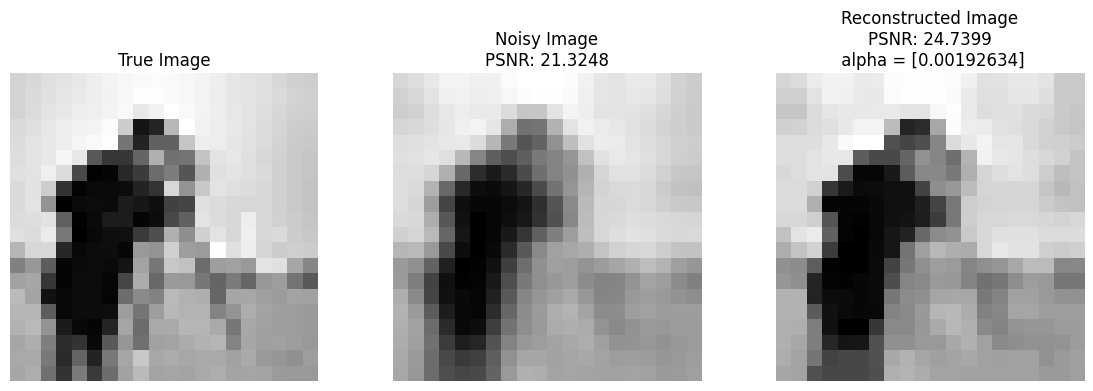

In [19]:
u_mpcc = u_mpcc.reshape((scale,scale))
plot_experiment(true,blurred,u_mpcc,alpha_mpcc)